# Match Survey Footprints

## Libraries

In [ ]:
import pandas as pd

import numpy as np

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization.wcsaxes.patches import Quadrangle
from astropy.wcs import WCS
from astropy.table import Table

from bs4 import BeautifulSoup

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mplPolygon
from matplotlib.patches import CirclePolygon
from matplotlib.path import Path

from shapely.geometry import Polygon as splyPolygon
from shapely.geometry import MultiPolygon
from shapely.ops import unary_union

import numpy as np

from collections import defaultdict

import json

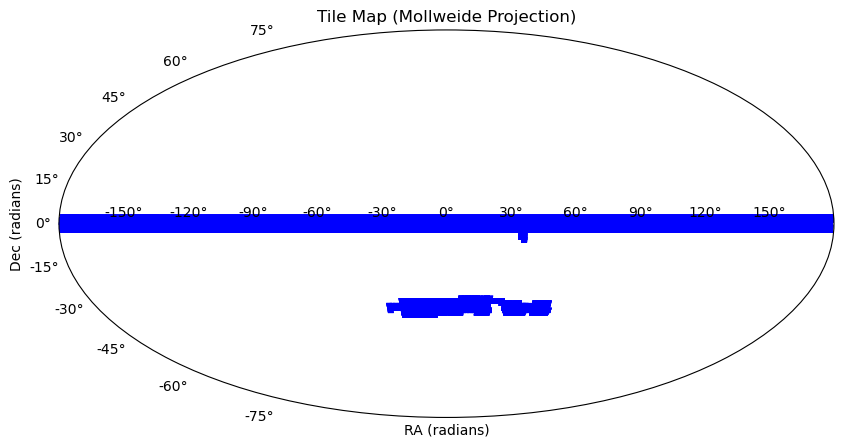

In [4]:
def split_tile_at_edge(ra_tile, dec_tile):
    """
    Split the tile polygon into two if it crosses the RA boundary of 180° or -180°.
    """
    polygons = []
    if np.any(ra_tile > np.pi) or np.any(ra_tile < -np.pi):  # Check for crossing the RA boundary
        ra_tile_1 = np.where(ra_tile > np.pi, ra_tile - 2 * np.pi, ra_tile)
        ra_tile_2 = np.where(ra_tile < -np.pi, ra_tile + 2 * np.pi, ra_tile)
        
        dec_tile_1 = dec_tile
        dec_tile_2 = dec_tile
        
        polygons.append((ra_tile_1, dec_tile_1))  # First part of the tile
        polygons.append((ra_tile_2, dec_tile_2))  # Second part of the tile
    else:
        polygons.append((ra_tile, dec_tile))
    
    return polygons


def create_tile_polygon_list(tile_file_path, tile_color):
    # Read the FITS file
    tile_table = Table.read(tile_file_path)
    tile_df = tile_table.to_pandas()
    
    # Initialize list for storing polygons
    polygon_list = []

    # Extract corner coordinates
    rac = tile_df[['rac1', 'rac2', 'rac3', 'rac4']].values
    decc = tile_df[['decc1', 'decc2', 'decc3', 'decc4']].values

    # Wrap RA values to the range [-180, 180]
    rac = (rac + 180) % 360 - 180  # This wraps values outside [-180, 180] into this range

    # Convert RA and Dec values to radians
    rac_rad = np.radians(rac)  # Convert RA to radians
    decc_rad = np.radians(decc)  # Convert Dec to radians

    # Iterate over the rows and create polygons
    for ra_tile, dec_tile in zip(rac_rad, decc_rad):
        # Create a list of corners for each tile, ensuring they are in the right order
        corners = list(zip(ra_tile, dec_tile))

        # Ensure the polygon is closed by appending the first corner at the end
        corners.append(corners[0])

        # Split the tile if it crosses the RA boundary
        split_polygons = split_tile_at_edge(np.array(ra_tile), np.array(dec_tile))

        # Add each polygon part (split if necessary) to the polygon list
        for ra_tile_part, dec_tile_part in split_polygons:
            polygon = mplPolygon(list(zip(ra_tile_part, dec_tile_part)), closed= True, edgecolor=tile_color, facecolor='none', linewidth=2)
            polygon_list.append(polygon)

    return polygon_list


def plot_tile_map(tile_file_path, tile_color='blue'):
    # Get the list of polygons
    polygons = create_tile_polygon_list(tile_file_path, tile_color)

    # Create a figure and a Mollweide projection plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='mollweide')

    # Add polygons (tiles) to the plot
    for poly in polygons:
        ax.add_patch(poly)

    # Set plot labels and title
    ax.set_xlabel('RA (radians)')
    ax.set_ylabel('Dec (radians)')
    ax.set_title('Tile Map (Mollweide Projection)')

    # Show the plot
    plt.show()

viking_tiles_path = '/data/mfonseca/survey_data/VIKING_data/viking_dr4_tileset.fits'

# Call the plot function with the path to your tile data
plot_tile_map(viking_tiles_path, tile_color='blue')
